In [76]:
#
############## IMPORTANT NOTE ##############
# Do NOT under any circumstances put your own directory onto the Git repo
# If you have anything like 'C:/User/username/...' in the code, DELETE before uploading
# Add a comment wherever you might add it, like:
#
# example_dir = '' # JH: hardcoded directory to cropped images here
#
# JH: Let me know and I will add a non-specific way to reach the files you need
# 
import numpy as np 
import pandas as pd
from PIL import Image
import os
import csv

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
dir_path = os.getcwd()              # JH: Gets current directory 
orig_path = dir_path + '\\original' # JH: Gets original data directory
Image.MAX_IMAGE_PIXELS = 5333152503 # JH: Increase max image size

In [74]:
#
# JH:
#
# Cuts a single image into smaller sections
# 
def crop(save_path, image, height, width, k):
    im = Image.open(image)                      # Opens image
    imWidth, imHeight = im.size                 # Gets raw pixel data
    for i in range(0, imWidth, height):
        for j in range(0, imHeight, width):
            box = (j, i, j+width, i+height)
            a = im.crop(box)                    # Crop using Image lib; cuts box size
            if not a.getbbox():                 # Image is entirely black
                continue                        # Skip section and go to next iteration
            try:
                a.save(os.path.join(save_path,"IM-%s.png" % k)) # Save in separate folder as PNG
            except:
                print("Failed to save image")   # Prompt user of a failure
            k +=1
    return

#
# JH:
# 
# Gets RGB values of an image
#
def rgb(image):
    im = Image.open(image)
    imWidth, imHeight = im.size
    pixels = list(im.getdata())                                     # Raw pixel RGB values
    rgbValues = np.array(pixels).reshape((imWidth, imHeight, 4))    # Reshape to n x 3
    return rgbValues                                                # Return [R, G, B]

#
# JH:
# 
# Creates labels for data
# Array is n x 3 dim
#
# Labels:
#   -1 => Water
#    0 => Unknown
#    1 => Land
#
def rgb_label(array):
    labels = []
    l, w, _ = array.shape
    for i in range(l):
        for j in range(w):
            # Condition for Water:
            # All blue; no RG; blue has the highest impact
            if((array[i][j][2] == 255) and (array[i][j][0] != 255)):
                labels.append(-1)
            elif((array[i][j][0] == 0) and (array[i][j][1] == 0)):
                labels.append(-1)
            elif((array[i][j][2] > array[i][j][1]) and (array[i][j][2] > array[i][j][0])):
                labels.append(-1)
            # Condition for Land:
            # No blue; yellowish color; large difference btw R and B
            elif(array[i][j][2] == 0):
                labels.append(1)
            elif(array[i][j][0] - array[i][j][2] < 100):
                labels.append(1)
            # Condition for Unknown:
            # Anything else
            else:
                labels.append(0)
    return labels

#
# JH:
# 
# Creates labels for data from separate r, g, b values
# Used for averages
#
# Labels:
#   -1 => Water
#    0 => Unknown
#    1 => Land
#
def label(r, g, b):
    labels = []
    for i in range(len(r)):
        # Condition for Water:
        # All blue; no RG; blue has the highest impact
        if((b[i] == 255) and (r[i] != 255)):
            labels.append(-1)
        elif((r[i] == 0) and (g[i] == 0)):
            labels.append(-1)
        elif((b[i] > g[i]) and (b[i] > r[i])):
            labels.append(-1)
        # Condition for Land:
        # No blue; yellowish color; large difference btw R and B
        elif(b[i] == 0):
            labels.append(1)
        elif(r[i] - b[i] < 100):
            labels.append(1)
        # Condition for Unknown:
        # Anything else
        else:
            labels.append(0)
    return labels

'''
##### JH: WIP; function to do all the data prep #####

#
# JH:
# 
# Selects which data size to use
# Does so for every image
# May cause RAM overflow (minimum 21GB free needed)
#
# Input options (must be string):
#   200p
#   100p
#   1p
#
def select_all_data(choice, osys):
    data = pd.DataFrame()
    images = [os.path.join(orig_path, f) for f in os.listdir(orig_path) if os.path.isfile(os.path.join(orig_path, f))]
    if(osys == 'windows'):
        save_path = dir_path + '\\' + choice
    else:
        save_path = dir_path + '/' + choice
    imNum = 0
    if(choice == '200p'):
        for image in images:
            tempDF = pd.DataFrame()
            crop(save_path, image, 200, 200, 0)
            croppedImages = [os.path.join(save_path, f) for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
            rgbAv = []
            rAv = []
            gAv = []
            bAv = []
            positions = []
            # Calculate average RGB for 200 x 200 image
            # This gives BASIC classification
            for im in croppedImages:
                tempVal = rgb(im)
                l, w, c = tempVal.shape
                avg = [0, 0, 0]
                for i in range(l):
                    for j in range(w):
                        for k in range(c):
                            avg[j] += tempVal[l][w][k]
                        positions.append(imNum)
                #rgbAv.append(avg)
                rAv.append(avg[0]) # R average for window
                gAv.append(avg[1]) # G avg
                bAv.append(avg[2]) # B avg
                imNum += 1         # Move to next window
            #classes = rgb_label(rgbAv)
            classes = label(rAv, gAv, bAv)

            if(1 == 0):
                # Store data into dataFrame
                # Name by image (for reconstruction)
                data[f"R_{image}"] = rgbAv[0]
                data[f"G_{image}"] = rgbAv[1]
                data[f"B_{image}"] = rgbAv[2]
                data[f"Labels_{image}"] = classes
                # Store data into temp dataFrame
                #tempDF["R"] = rgbAv[0]
                #tempDF["G"] = rgbAv[1]
                #tempDF["B"] = rgbAv[2]
            tempDF["R"] = rAv
            tempDF["G"] = gAv
            tempDF["B"] = gAv
            tempDF["Im_Positions"] = positions
            tempDF["Labels"] = classes
            
            # Add data to existing dataframe
            data = pd.concat([data, tempDF])
    elif(choice == '100p'):
        for image in images:
            tempDF = pd.DataFrame()
            crop(save_path, image, 100, 100, 0)
            croppedImages = [os.path.join(save_path, f) for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

            # Calculate average RGB for 100 x 100 image
            # This gives BASIC classification
            for im in croppedImages:
                tempVal = rgb(im)
                l, w, c = tempVal.shape
                avg = [0, 0, 0]
                for i in range(l):
                    for j in range(w):
                        for k in range(c):
                            avg[j] += tempVal[l][w][k]  # Calculates average
                        positions.append(imNum)         # Appends position for reconstruction
                #rgbAv.append(avg)
                rAv.append(avg[0])
                gAv.append(avg[1])
                bAv.append(avg[2])
                imNum += 1
            #classes = rgb_label(rgbAv)
            classes = label(rAv, gAv, bAv)

            if(1 == 0):
                # Store data into dataFrame
                # Name by image (for reconstruction)
                tempDF[f"R_{image}"] = rgbAv[0]
                tempDF[f"G_{image}"] = rgbAv[1]
                tempDF[f"B_{image}"] = rgbAv[2]
                tempDF[f"Labels_{image}"] = classes
            
                # Store data into temp dataFrame
                #tempDF["R"] = rgbAv[0]
                #tempDF["G"] = rgbAv[1]
                #tempDF["B"] = rgbAv[2]
            tempDF["R"] = rAv
            tempDF["G"] = gAv
            tempDF["B"] = gAv
            tempDF["Im_Positions"] = positions
            tempDF["Labels"] = classes
            
            # Add data to existing dataframe
            data = pd.concat([data, tempDF])
    elif(choice == '1p'):
        for image in images:
            tempDF = pd.DataFrame()
            tempVals = rgb(image)
            classes = label(tempVals)

            if(1 == 0):
                # Store data into dataFrame
                # Name by image (for reconstruction)
                tempDF[f"R_{image}"] = tempVals[0]
                tempDF[f"G_{image}"] = tempVals[1]
                tempDF[f"B_{image}"] = tempVals[2]
                tempDF[f"Labels_{image}"] = classes

            # Store data into temp dataFrame
            tempDF["R"] = tempVals[0]
            tempDF["G"] = tempVals[1]
            tempDF["B"] = tempVals[2]
            tempDF["Labels"] = classes

            # Add data to existing dataframe
            data = pd.concat([data, tempDF])
    else:
        return False # Invalid choice
    return data

#
# JH:
# 
# Selects which data size to use
# Creates data for 1 image
# Prevents RAM overflow to some extent (14GB needed)
#
# Input options (must be string):
#   200p
#   100p
#   1p
#
def select_data(choice, image_path, image, osys):
    #data = pd.DataFrame(columns=["R","G","B","Im_positions","Labels"])
    data = pd.DataFrame()
    if(osys == 'windows'):
        save_path = dir_path + '\\' + choice + image
    else:
        save_path = dir_path + '/' + choice + image
    if(os.path.exists(save_path) == False):
        os.mkdir(save_path)
    imNum = 0
    if(choice == '200p'):
        tempDF = pd.DataFrame()
        crop(save_path, image_path, 200, 200, 0)
        croppedImages = [os.path.join(save_path, f) for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
        rgbAv = []
        rAv = []
        gAv = []
        bAv = []
        positions = []
        # Calculate average RGB for 200 x 200 image
        # This gives BASIC classification
        for im in croppedImages:
            tempVal = rgb(im)
            l, w, _ = tempVal.shape
            avg = [0, 0, 0]
            for i in range(l):
                for j in range(w):
                    for k in range(3):
                        avg[k] += tempVal[i][j][k]
                    positions.append(imNum)
            #rgbAv.append(avg)
            rAv.append(avg[0]) # R average for window
            gAv.append(avg[1]) # G avg
            bAv.append(avg[2]) # B avg
            imNum += 1         # Move to next window
        #classes = rgb_label(rgbAv)
        classes = label(rAv, gAv, bAv)

        if(1 == 0):
            # Store data into dataFrame
            # Name by image (for reconstruction)
            data[f"R_{image}"] = rgbAv[0]
            data[f"G_{image}"] = rgbAv[1]
            data[f"B_{image}"] = rgbAv[2]
            data[f"Labels_{image}"] = classes

            # Store data into temp dataFrame
            #tempDF["R"] = rgbAv[0]
            #tempDF["G"] = rgbAv[1]
            #tempDF["B"] = rgbAv[2]
        tempDF["R"] = rAv
        tempDF["G"] = gAv
        tempDF["B"] = gAv
        tempDF["Im_Positions"] = positions
        tempDF["Labels"] = classes
        
        # Add data to existing dataframe
        data = pd.concat([data, tempDF])
    elif(choice == '100p'):
        tempDF = pd.DataFrame()
        crop(save_path, image_path, 100, 100, 0)
        croppedImages = [os.path.join(save_path, f) for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

        # Calculate average RGB for 100 x 100 image
        # This gives BASIC classification
        for im in croppedImages:
            tempVal = rgb(im)
            l, w, _ = tempVal.shape
            avg = [0, 0, 0]
            for i in range(l):
                for j in range(w):
                    for k in range(3):
                        avg[k] += tempVal[i][j][k]
                    positions.append(imNum)
            #rgbAv.append(avg)
            rAv.append(avg[0])
            gAv.append(avg[1])
            bAv.append(avg[2])
            imNum += 1
        #classes = rgb_label(rgbAv)
        classes = label(rAv, gAv, bAv)

        if(1 == 0):
            # Store data into dataFrame
            # Name by image (for reconstruction)
            
            tempDF[f"R_{image}"] = rgbAv[0]
            tempDF[f"G_{image}"] = rgbAv[1]
            tempDF[f"B_{image}"] = rgbAv[2]
            tempDF[f"Labels_{image}"] = classes

            # Store data into temp dataFrame
            #tempDF["R"] = rgbAv[0]
            #tempDF["G"] = rgbAv[1]
            #tempDF["B"] = rgbAv[2]
        tempDF["R"] = rAv
        tempDF["G"] = gAv
        tempDF["B"] = gAv
        tempDF["Im_Positions"] = positions
        tempDF["Labels"] = classes
        
        # Add data to existing dataframe
        data = pd.concat([data, tempDF])
    elif(choice == '1p'):
        tempDF = pd.DataFrame()
        tempVals = rgb(image_path)
        print("Got RGB")
        classes = label(tempVals)
        print("Got classes")

        # Store data into dataFrame
        if(1 == 0):
            # Name by image (for reconstruction)
            tempDF[f"R_{image}"] = tempVals[0]
            tempDF[f"G_{image}"] = tempVals[1]
            tempDF[f"B_{image}"] = tempVals[2]
            tempDF[f"Labels_{image}"] = classes

        # Store data into temp dataFrame
        tempDF["R"] = tempVals[0]
        tempDF["G"] = tempVals[1]
        tempDF["B"] = tempVals[2]
        tempDF["Labels"] = classes

        # Add data to existing dataframe
        data = pd.concat([data, tempDF])
    else:
        return False # Invalid choice
    return data
'''


In [62]:
# JH: Choose data
#data = select_all_data('200p', 'windows')
'''
images = [file for file in os.listdir(orig_path) if file.endswith(".tif")]
os.chdir(orig_path)
for i in range(1, 8):
    im = orig_path + '\\' + images[i]
    print(images[i])
    data = select_data('200p', im, images[i], 'windows')
os.chdir('../')
'''

images = [file for file in os.listdir(orig_path) if file.endswith(".tif")]
os.chdir(orig_path)
for i in range(1, 8):
    im = orig_path + '\\' + images[i]
    print(images[i])
    save_path = dir_path + '\\200p' + images[i]
    if(os.path.exists(save_path) == False):
        os.mkdir(save_path)
    data = crop(save_path, im, 200, 200, 0)
os.chdir('../')

LB_10022020_Ortho-0-0.tif
LB_10022020_Ortho-0-1.tif
LB_10022020_Ortho-0-2.tif
LB_10022020_Ortho-0-3.tif
LB_10072021_Ortho-0-3.tif
LB_20201117_Ortho-0-0.tif
LB_20201117_Ortho-0-1.tif


In [63]:
images = [file for file in os.listdir(orig_path) if file.endswith(".tif")]
for i in range(1, 8):
    im = orig_path + '\\' + images[i]
    print(images[i])
    save_path = dir_path + '\\100p' + images[i]
    if(os.path.exists(save_path) == False):
        os.mkdir(save_path)
    data = crop(save_path, im, 100, 100, 0)
os.chdir('../')

LB_10022020_Ortho-0-0.tif
LB_10022020_Ortho-0-1.tif
LB_10022020_Ortho-0-2.tif
LB_10022020_Ortho-0-3.tif
LB_10072021_Ortho-0-3.tif
LB_20201117_Ortho-0-0.tif
LB_20201117_Ortho-0-1.tif


In [142]:
data = pd.DataFrame()
window = False
for i in range(1, 8):
    #path = dir_path + '\\cropped\\200p' + images[i]
    #path = dir_path + '\\cropped\\100p' + images[i]
    path = dir_path
    os.chdir(path)
    croppedImages = [file for file in os.listdir(path) if file.endswith(".png")]

    tempDF = pd.DataFrame()
    if(window == True):
        imNum = 0
        rAv = []
        gAv = []
        bAv = []
        positions = []
        for im in croppedImages:
            # Calculate average RGB for 200 x 200 image
            # This gives BASIC classification
            tempVal = rgb(im)
            l, w, _ = tempVal.shape
            avg = [0, 0, 0]
            for i in range(l):
                for j in range(w):
                    for k in range(3):
                        avg[k] += tempVal[i][j][k]
            positions.append(imNum)
            #rgbAv.append(avg)
            # Calculate total number of iterations
            s = l * w
            rAv.append(avg[0]/s) # R average for window
            gAv.append(avg[1]/s) # G avg
            bAv.append(avg[2]/s) # B avg
            imNum += 1         # Move to next window
        
        #classes = rgb_label(rgbAv)
        classes = label(rAv, gAv, bAv)

        tempDF["R"] = rAv
        tempDF["G"] = gAv
        tempDF["B"] = gAv
        tempDF["Im_Positions"] = positions
        tempDF["Labels"] = classes
    else:
        for im in croppedImages:
            tempVals = rgb(im)
            classes = rgb_label(tempVals)

            # Reshape RGB data to be stored
            l, w, c = tempVals.shape
            tempVals = tempVals.reshape((l*w,c))

            # Store data into temp dataFrame
            tempDF["R"] = tempVals[:, 0]     # R value of pixel
            tempDF["G"] = tempVals[:, 1]     # G value of pixel
            tempDF["B"] = tempVals[:, 2]     # B value of pixel
            tempDF["Alpha"] = tempVals[:, 3] # Alpha value of pixel
            tempDF["Labels"] = classes

            # Add data to existing dataframe
            data = pd.concat([data, tempDF])
    csv_name = os.path.splitext(im)[0] + '_Allp.csv'
    tempDF.to_csv(os.path.join(path,csv_name),index=False)

    data = pd.concat([data, tempDF])
os.chdir('../')

In [99]:
###### OF NOTE ######
# JH: Everything up until here is run to create the dataframe from the data
# You can load in one of the csv's (or all) instead of running the above
data.head() # JH: Shows quick inspection of data

,R,G,B,Im_Positions,Labels
0,223.0073,222.2089,222.2089,0,1
1,194.3061,194.4003,194.4003,1,1
2,142.6321,129.9296,129.9296,2,1
3,131.6249,129.7757,129.7757,3,1
4,191.6805,187.8309,187.8309,4,1


In [2]:
# JH: Split data into X, Y
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
data = pd.read_csv('cropped/100pLB_10022020_Ortho-0-0/IM-9999.csv')
X_data = data.drop(["Labels"], axis= 1)
Y_data = data["Labels"]

# JH: Split data into train/test at 80/20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)

In [3]:
###### OF NOTE ######
# JH: I removed the parts that I did for the mid stage report. They may be added later once we are approaching completion of the project.
#     As of right now, they would hinder your dev progress

#
# JH: Add SRR code here
#
kmeans = KMeans(n_clusters=2, init='random',n_init=10).fit(X_train) # JH: Basic k-means implementation
unsupLabels = kmeans.labels_                              # JH: Get labels

In [4]:
unsupTest = kmeans.predict(X_test)                        # JH: Basic evaluation

In [5]:
#
# JH: Add ID code here
#
###### OF NOTE ######
# The Y data here are the unsupervised labels generated from unsupLabels
# The below lines should be used when the labeller is complete
#
#knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, unsupLabels) # JH: Basic kNN impelementation w/ finished unsup part
#supTest = knn.predict(X_test)                                       # JH: kNN test
#score = knn.score(X_test, unsupTest)                                # JH: kNN eval
#
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, Y_train) # JH: Basic kNN impelementation w/o finished unsup part

In [6]:
supTest = knn.predict(X_test)        # JH: kNN test
score = knn.score(X_test, Y_test)    # JH: kNN eval
print(score)

0.903794156127344


In [ ]:
'''So I have fitted the KNN model based on the csv's generated by Jack but 
labelling them on that basis seems unfit since position info is inaccurate for visualisation.
To overcome this I have Downsampled the Ortho imgs to jpgs
also in the labeller i have decided an arbitrary margin of around 40%, since the 
Cluster Model groups up shades of blues and greens in one cluster and the info from images 
that water boundary on average start from right to middle around 50%
any water(blue-green groups from left to mid 40% are converted to land label)'''

In [4]:
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
img = mpl.image.imread(r'Data\transformed\LB_09182020_Ortho.jpg')
knnModel = joblib.load(r'model\Kmeans.joblib')                    
def labeller(img):                                                      #Given an img input
    m,n,_ = img.shape                                                   # return a dataframe with clustered
    df = pd.DataFrame(img.reshape(-1,3),columns=['R','G','B'])          # and adjusted  labels
    df = df/255.0
    labels = knnModel.predict(df)
    labels = labels.reshape(m,n)
    pos = []
    for i in range(m):
    # left correction 
        for j in range(0,int(n*0.45)):
            if labels[i][j]==1:
                labels[i][j]= 0
        for j in range(int(n*0.80),n):
            if labels[i][j]==0:
                labels[i][j]= 1
    labels = pd.Series(labels.reshape(m*n),name='label')
    df = pd.concat([df,labels],axis=1)
    for i in range(m):
        for j in range(n):
            pos.append([i,j])

    posdf = pd.DataFrame(pos,columns=['xPos','yPos'])
    df = pd.concat([df,posdf],axis=1)
    return df

Text(0.5, 1.0, 'Clustered')

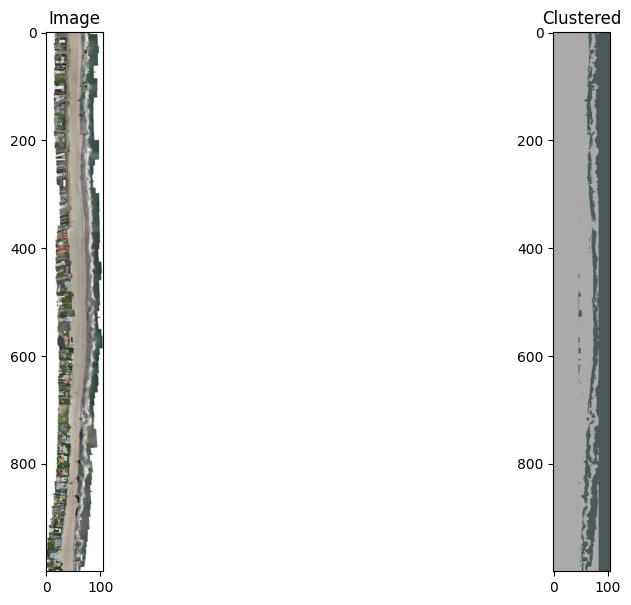

In [7]:
img = mpl.image.imread(r'Data\transformed\LB_09182020_Ortho.jpg')
m,n,_ = img.shape
df = labeller(img)
# preds = knnModel.predict(df[['R','G','B']]);
clustered_img = knnModel.cluster_centers_[df['label']]
clustered_img = clustered_img.reshape(img.shape)
fig, axes = plt.subplots(1,2,figsize=(12,7))

axes[0].imshow(img)
axes[0].set_title('Image')

axes[1].imshow(clustered_img)
axes[1].set_title('Clustered')